# Extract blue lines

Mainly Hβ, He II, He I, [O III], [Ar IV], [N I], Si II

## Library imports and data loading

Copied from the `02-01-Raman-Wings-IR-Source-C` notebook:

In [1]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from mpdaf.obj import Cube
import regions
import sys
from whispy import moments
from whispy import extract

sns.set_context("talk")
sns.set_color_codes()

In [2]:
moments.FIGPATH = Path("../../figs")
moments.SAVEPATH = Path("../../data")

Load the co-added datacube (cube1) and the good-seeing one (cube2).

In [3]:
datapath = Path("/Users/will/Work/Muse-Hii-Data/SMC-NGC-346/")
file1 = "ADP.2017-10-16T11_04_19.247.fits"
file2 = "ADP.2016-10-12T05_43_23.882.fits"
cube1 = Cube(str(datapath / file1))
cube2 = Cube(str(datapath / file2))

## Use moments to extract the Hβ line and other blue lines

Use a generic name for the cube over the broad wavelength range to reduce need for edits when we repurpose this later.

In [4]:
wavmin, wavmax = 4600, 5400

We mainly work with the good seeing cube, but also use the summed one (mcube).

In [5]:
cube = cube2.select_lambda(wavmin, wavmax)
mcube = cube1.select_lambda(wavmin, wavmax)

In [6]:
# Position of mYSO
x, y = 116, 147
# position of B0 star SSN 43
xb, yb = 95, 163
# position of B0 star SSN 40
xbb, ybb = 121, 133
m = 3

boxes = {
    "SSN 152+168": regions.BoundingBox(
        iymin=y - m,
        iymax=y + m,
        ixmin=x - m,
        ixmax=x + m,
    ),
    #    "BG 152+168": regions.BoundingBox(
    #        iymin=y-2*m, iymax=y+2*m, ixmin=x-2*m, ixmax=x+2*m,
    #    ),
    "SSN 43": regions.BoundingBox(
        iymin=yb - m,
        iymax=yb + m,
        ixmin=xb - m,
        ixmax=xb + m,
    ),
    #    "BG 43": regions.BoundingBox(
    #        iymin=yb-2*m, iymax=yb+2*m, ixmin=xb-2*m, ixmax=xb+2*m,
    #    ),
    "SSN 40": regions.BoundingBox(
        iymin=ybb - m,
        iymax=ybb + m,
        ixmin=xbb - m,
        ixmax=xbb + m,
    ),
    #    "BG 40": regions.BoundingBox(
    #        iymin=ybb-2*m, iymax=ybb+2*m, ixmin=xbb-2*m, ixmax=xbb+2*m,
    #    ),
    "blue": regions.BoundingBox(iymin=75, iymax=140, ixmin=15, ixmax=40),
    "red": regions.BoundingBox(iymin=200, iymax=250, ixmin=210, ixmax=300),
    "magenta": regions.BoundingBox(iymin=10, iymax=50, ixmin=100, ixmax=150),
    "green": regions.BoundingBox(iymin=10, iymax=100, ixmin=200, ixmax=300),
    "cyan": regions.BoundingBox(iymin=170, iymax=210, ixmin=90, ixmax=120),
}


These are the ranges that the continum is fitted to. It is OK if they contain some weak lines.

In [7]:
wavranges = [
    (4600, 4620),
    (4720, 4730),
    (4760, 4800),
    (4937, 4947),
    (4974, 4984),
    (5028, 5038),
    (5070, 5100),
    (5120, 5145),
    (5220, 5260),
    (5330, 5390),
]

        Use get_overlap_slices instead. [warnings]
        Use get_overlap_slices instead. [warnings]
        Use get_overlap_slices instead. [warnings]
        Use get_overlap_slices instead. [warnings]
        Use get_overlap_slices instead. [warnings]
        Use get_overlap_slices instead. [warnings]
        Use get_overlap_slices instead. [warnings]
        Use get_overlap_slices instead. [warnings]


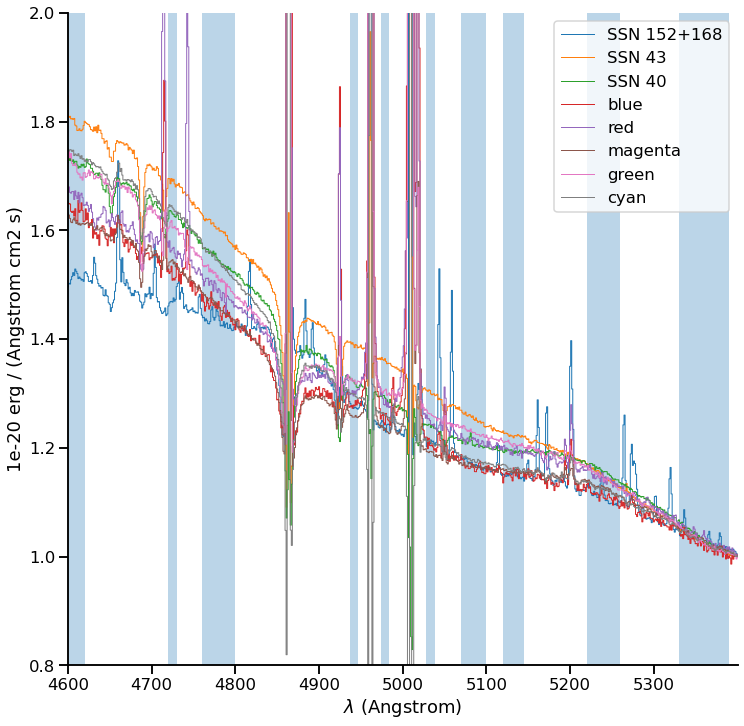

In [8]:
fig, ax = plt.subplots(figsize=(12, 12))
for label, box in boxes.items():
    yslice, xslice = box.slices
    spec = cube[:, yslice, xslice].mean(axis=(1, 2))
    (spec / spec.data[-1]).plot(label=label)

for wavrange in wavranges:
    ax.axvspan(*wavrange, alpha=0.3)
ax.legend()
ax.set(
    ylim=[0.8, 2.0],
)
sns.despine()

In [9]:
yslice, xslice = boxes["SSN 152+168"].slices
subcube = cube[:, yslice, xslice]
contcube = extract.fit_continuum(
    subcube,
    wav_ranges=wavranges,
    deg=6,
    median=False,
)

extract.fit_continuum: row 0


        Use get_overlap_slices instead. [warnings]


[(4000.0, 8000.0)]

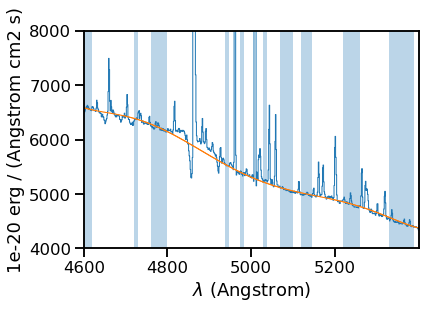

In [10]:
fig, ax = plt.subplots()
subcube.mean(axis=(1, 2)).plot()
contcube.mean(axis=(1, 2)).plot()
for wavrange in wavranges:
    ax.axvspan(*wavrange, alpha=0.3)
ax.set(ylim=[4000, 8000])

In [11]:
yslice, xslice = boxes["green"].slices
subcube = mcube[:, yslice, xslice]
contcube = extract.fit_continuum(
    subcube,
    wav_ranges=wavranges,
    deg=6,
    median=False,
)

        Use get_overlap_slices instead. [warnings]


extract.fit_continuum: row 0
extract.fit_continuum: row 10
extract.fit_continuum: row 20
extract.fit_continuum: row 30
extract.fit_continuum: row 40
extract.fit_continuum: row 50
extract.fit_continuum: row 60
extract.fit_continuum: row 70
extract.fit_continuum: row 80


[(0.0, 180.0)]

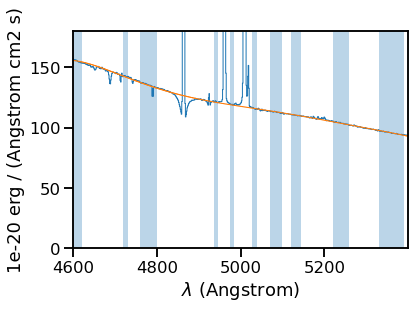

In [12]:
fig, ax = plt.subplots()
subcube.mean(axis=(1, 2)).plot()
contcube.mean(axis=(1, 2)).plot()
for wavrange in wavranges:
    ax.axvspan(*wavrange, alpha=0.3)
ax.set(ylim=[0, 180])

So it turns out that a high order polynomial is needed because of the broad wavelength range.  And it is better to use the full set of points rather than the median *and* that is faster too!

Calculating the median must be expensive.

In [13]:
contcube = extract.fit_continuum(
    cube,
    wav_ranges=wavranges,
    deg=6,
    median=False,
)

extract.fit_continuum: row 0


/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/polynomial/polyutils.py:299: RuntimeWarning: divide by zero encountered in double_scalars
  off = (old[1]*new[0] - old[0]*new[1])/oldlen
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/polynomial/polyutils.py:300: RuntimeWarning: divide by zero encountered in true_divide
  scl = newlen/oldlen
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/polynomial/polyutils.py:368: RuntimeWarning: invalid value encountered in add
  return off + scl*x


extract.fit_continuum: row 10
extract.fit_continuum: row 20
extract.fit_continuum: row 30
extract.fit_continuum: row 40
extract.fit_continuum: row 50
extract.fit_continuum: row 60
extract.fit_continuum: row 70
extract.fit_continuum: row 80
extract.fit_continuum: row 90
extract.fit_continuum: row 100


/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1671: RankWarning: The fit may be poorly conditioned
  return pu._fit(chebvander, x, y, deg, rcond, full, w)


extract.fit_continuum: row 110
extract.fit_continuum: row 120
extract.fit_continuum: row 130
extract.fit_continuum: row 140
extract.fit_continuum: row 150
extract.fit_continuum: row 160
extract.fit_continuum: row 170
extract.fit_continuum: row 180
extract.fit_continuum: row 190
extract.fit_continuum: row 200
extract.fit_continuum: row 210
extract.fit_continuum: row 220
extract.fit_continuum: row 230
extract.fit_continuum: row 240
extract.fit_continuum: row 250
extract.fit_continuum: row 260
extract.fit_continuum: row 270
extract.fit_continuum: row 280
extract.fit_continuum: row 290
extract.fit_continuum: row 300
extract.fit_continuum: row 310
extract.fit_continuum: row 320


In [14]:
mcontcube = extract.fit_continuum(
    mcube,
    wav_ranges=wavranges,
    deg=6,
    median=False,
)

extract.fit_continuum: row 0


/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1671: RankWarning: The fit may be poorly conditioned
  return pu._fit(chebvander, x, y, deg, rcond, full, w)


extract.fit_continuum: row 10
extract.fit_continuum: row 20
extract.fit_continuum: row 30
extract.fit_continuum: row 40
extract.fit_continuum: row 50
extract.fit_continuum: row 60
extract.fit_continuum: row 70
extract.fit_continuum: row 80
extract.fit_continuum: row 90
extract.fit_continuum: row 100
extract.fit_continuum: row 110


/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/polynomial/polyutils.py:299: RuntimeWarning: divide by zero encountered in double_scalars
  off = (old[1]*new[0] - old[0]*new[1])/oldlen
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/polynomial/polyutils.py:300: RuntimeWarning: divide by zero encountered in true_divide
  scl = newlen/oldlen
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/polynomial/polyutils.py:368: RuntimeWarning: invalid value encountered in add
  return off + scl*x


extract.fit_continuum: row 120
extract.fit_continuum: row 130
extract.fit_continuum: row 140
extract.fit_continuum: row 150
extract.fit_continuum: row 160
extract.fit_continuum: row 170
extract.fit_continuum: row 180
extract.fit_continuum: row 190
extract.fit_continuum: row 200
extract.fit_continuum: row 210
extract.fit_continuum: row 220
extract.fit_continuum: row 230
extract.fit_continuum: row 240
extract.fit_continuum: row 250
extract.fit_continuum: row 260
extract.fit_continuum: row 270
extract.fit_continuum: row 280
extract.fit_continuum: row 290
extract.fit_continuum: row 300
extract.fit_continuum: row 310
extract.fit_continuum: row 320


        Use get_overlap_slices instead. [warnings]
        Use get_overlap_slices instead. [warnings]
        Use get_overlap_slices instead. [warnings]
        Use get_overlap_slices instead. [warnings]
        Use get_overlap_slices instead. [warnings]
        Use get_overlap_slices instead. [warnings]
        Use get_overlap_slices instead. [warnings]
        Use get_overlap_slices instead. [warnings]


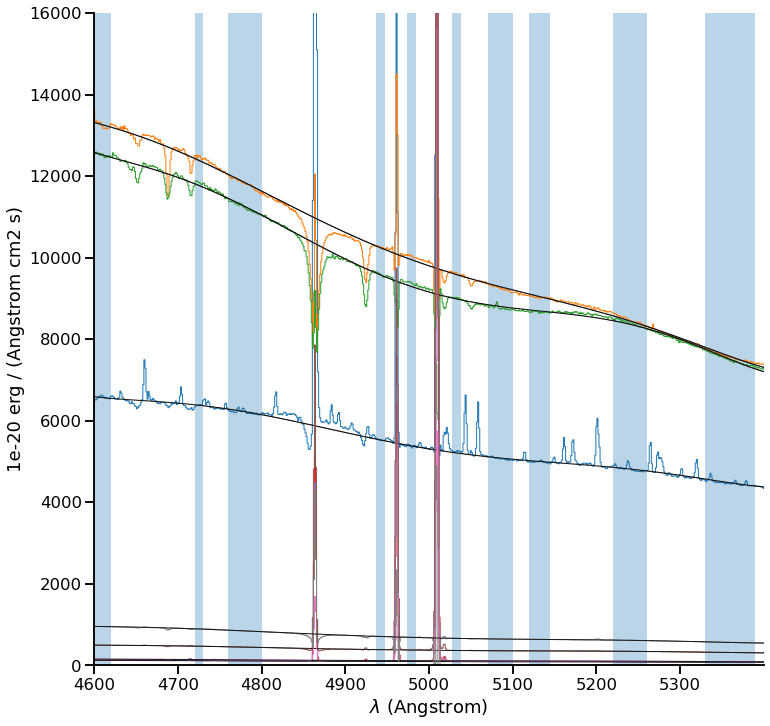

In [15]:
fig, ax = plt.subplots(figsize=(12, 12))
for box in boxes.values():
    yslice, xslice = box.slices
    spec = cube[:, yslice, xslice].mean(axis=(1, 2))
    cspec = contcube[:, yslice, xslice].mean(axis=(1, 2))
    spec.plot()
    cspec.plot(color="k")

for wavrange in wavranges:
    ax.axvspan(*wavrange, alpha=0.3)
ax.set(
    ylim=[0, 16000],
)
sns.despine()

In [16]:
prefix = f"../../big-data/ngc346-sharp-{wavmin:d}-{wavmax:d}-cube"
prefix

'../../big-data/ngc346-sharp-4600-5400-cube'

In [17]:
csubcube = cube - contcube
cdivcube = cube / contcube

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)


In [18]:
csubcube.write(
    f"{prefix}-contsub.fits",
    savemask="nan",
)
cdivcube.write(
    f"{prefix}-contdiv.fits",
    savemask="nan",
)
contcube.write(
    f"{prefix}-cont.fits",
    savemask="nan",
)

In [19]:
mprefix = f"../../big-data/ngc346-{wavmin:d}-{wavmax:d}-cube"
mprefix

'../../big-data/ngc346-4600-5400-cube'

In [20]:
mcsubcube = mcube - mcontcube
mcdivcube = mcube / mcontcube

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)


In [21]:
mcsubcube.write(
    f"{mprefix}-contsub.fits",
    savemask="nan",
)
mcdivcube.write(
    f"{mprefix}-contdiv.fits",
    savemask="nan",
)
mcontcube.write(
    f"{mprefix}-cont.fits",
    savemask="nan",
)

## Inspect the blue spectrum

Compare bow shock to median of cube

In [22]:
mboxes = {
    "sw filament": regions.BoundingBox(
        iymin=30,
        iymax=50,
        ixmin=300,
        ixmax=330,
    ),
    "bow shock": regions.BoundingBox(
        iymin=165,
        iymax=205,
        ixmin=240,
        ixmax=290,
    ),
    "w filament": regions.BoundingBox(
        iymin=100,
        iymax=130,
        ixmin=25,
        ixmax=55,
    ),
    "c filament": regions.BoundingBox(
        iymin=195,
        iymax=210,
        ixmin=155,
        ixmax=195,
    ),
}

In [23]:
yslice, xslice = mboxes["bow shock"].slices
bowspec_sub = mcsubcube[:, yslice, xslice].mean(axis=(1, 2))
avspec_sub = mcsubcube.median(axis=(1, 2))
medspec_sub = mcsubcube.median(axis=(1, 2))

        Use get_overlap_slices instead. [warnings]


In [24]:
hi_wavs = [4641.81, 4650.00, 4685.71, 4711.37, 4740.17]
med_wavs = [4658.10, 4701.62, 4713.14, 4861.32, 4921.93, 4931.32]

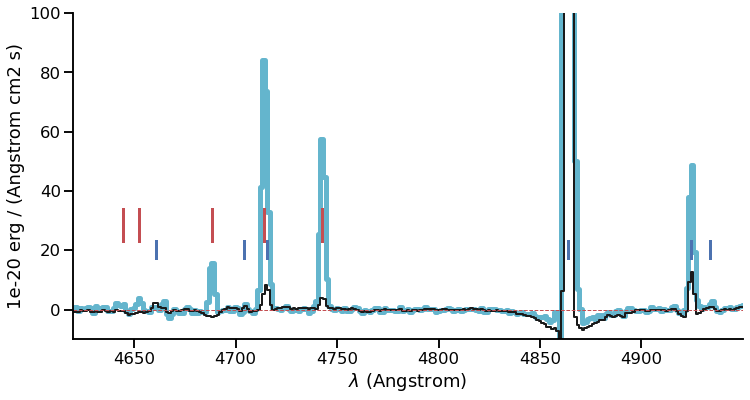

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))
wav1, wav2 = 4620, 4950
(bowspec_sub).subspec(wav1, wav2).plot(linewidth=5, alpha=1.0, color="c")
(medspec_sub).subspec(wav1, wav2).plot(color="k", linewidth=2)
for wav in hi_wavs:
    ax.axvline(
        wav * (1.0 + 160.0 / 3e5), ymin=0.3, ymax=0.4, color="r", linewidth=3, alpha=1.0
    )
for wav in med_wavs:
    ax.axvline(
        wav * (1.0 + 160.0 / 3e5),
        ymin=0.25,
        ymax=0.3,
        color="b",
        linewidth=3,
        alpha=1.0,
    )
ax.axhline(0.0, linestyle="dashed", color="r", linewidth=1)
ax.set(
    ylim=[-10, 100],
)
sns.despine()
fig.savefig(moments.FIGPATH / "ngc346-bow-shock-spec-{wav1}-{wav2}.pdf")

Left to right:

* 4641, 4650: could be O II lines? seen from bow shock only, but weird if true
* 4658 [Fe III] BG only
* 4686 He II - bow shock only
* 4713 [Fe III] BG only (very weak)
* 4711+13 [Ar IV] + He I (and could also include [Ne IV] 4714, except that 4725 is not seen)
* 4740 [Ar IV]
* 4861 H beta
* 4921.93 He I
* 4931.32 [O III] - the very weak component of the triplet

The long wavelength side of the strong [O III] lines is less interesting:

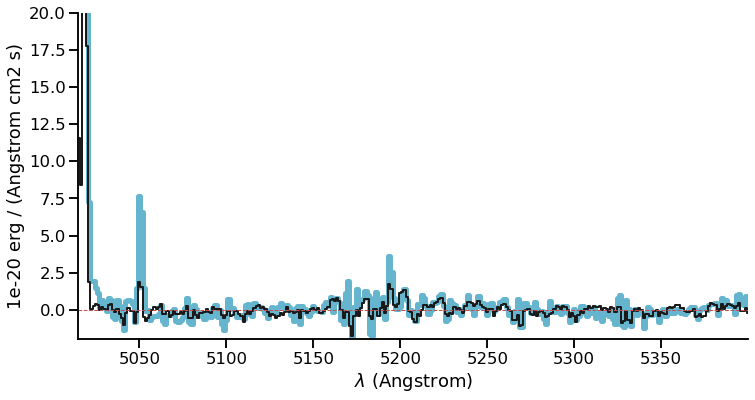

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))
wav1, wav2 = 5015, 5400
(bowspec_sub).subspec(wav1, wav2).plot(linewidth=5, alpha=1.0, color="c")
(medspec_sub).subspec(wav1, wav2).plot(color="k", linewidth=2)
# for wav in ariv_lines:
#    ax.axvline(wav*(1.0 + 160.0/3e5), ymin=0.3, ymax=0.4, color="k", linewidth=3, alpha=0.5)
ax.axhline(0.0, linestyle="dashed", color="r", linewidth=1)
ax.set(
    ylim=[-2, 20],
)
sns.despine()

He I line at 5047.74 and [Ar III] line at 5193.69

## Extract He II line

In [27]:
mom4686 = moments.find_moments(mcsubcube.select_lambda(4686, 4691))

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/whispy/moments.py:43: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)


In [28]:
dlam, _, _ = cube.get_step()
cont4686 = mcontcube.select_lambda(4686, 4691).mean(axis=0)
ew4686 = dlam * mom4686[0] / cont4686

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)


In [29]:
cont4686.write?

In [30]:
cont4686.write(moments.SAVEPATH / "ngc346-cont-4686-mean.fits", savemask="nan")
ew4686.write(moments.SAVEPATH / "ngc346-ew-4686-mean.fits", savemask="nan")

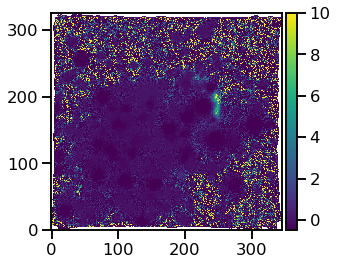

In [31]:
ew4686.plot(vmin=-0.5, vmax=10, colorbar="v")

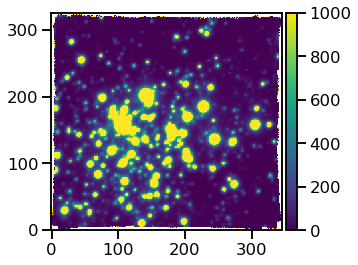

In [32]:
cont4686.plot(vmin=0, vmax=1000, colorbar="v")

In [33]:
mom4686[0].mask = mom4686[0].mask | (cont4686.data > 1000)

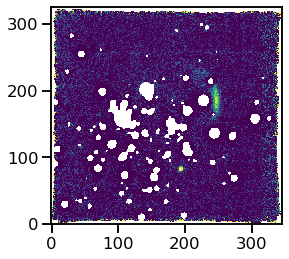

In [34]:
mom4686[0].rebin(1).plot(vmin=0, vmax=300)

In [35]:
mom_pars_4686 = dict(
    restwav=4685.68,
    irange=[-10, 1000],
    vrange=[-250, 550],
    srange=[0, 600],
)

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/whispy/moments.py:119: RuntimeWarning: invalid value encountered in log10
  f"log10 I({label})": np.log10(mom0.data[~m]),
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/whispy/moments.py:127: RuntimeWarning: invalid value encountered in log10
  f"log10 I({label})": np.log10(irange),


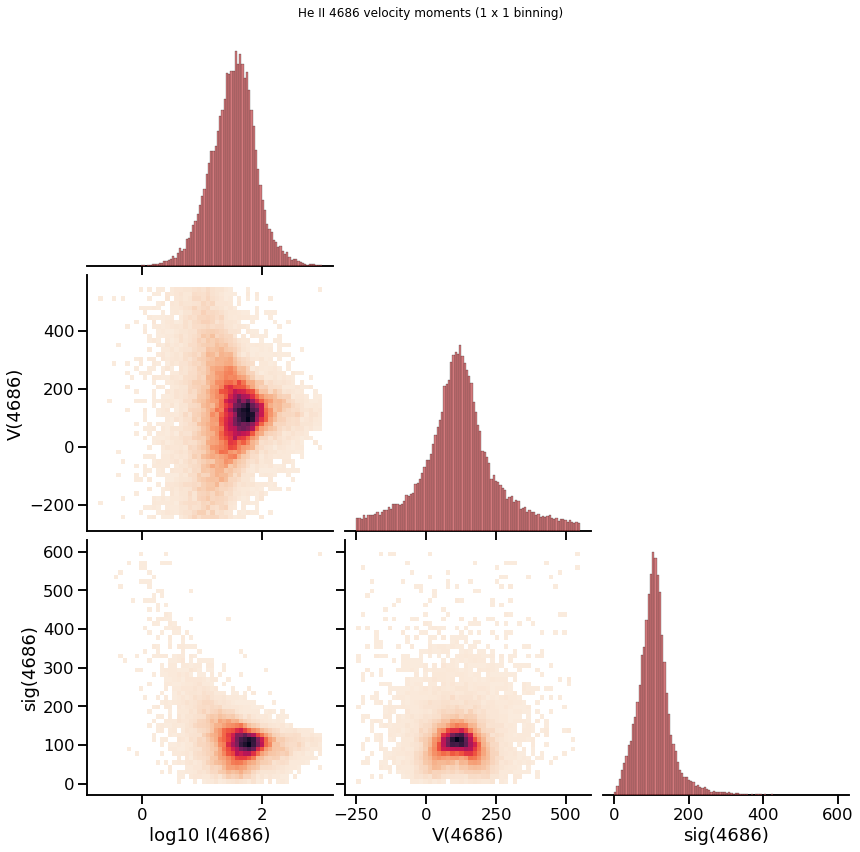

In [36]:
plot_pars_4686 = dict(
    ilabel="He II",
    label="4686",
    flabel="ngc346-heii",
    **mom_pars_4686,
)
g = moments.moments_corner_plot(
    mom4686,
    rebin=1,
    **plot_pars_4686,
)

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/whispy/moments.py:119: RuntimeWarning: invalid value encountered in log10
  f"log10 I({label})": np.log10(mom0.data[~m]),
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/whispy/moments.py:127: RuntimeWarning: invalid value encountered in log10
  f"log10 I({label})": np.log10(irange),


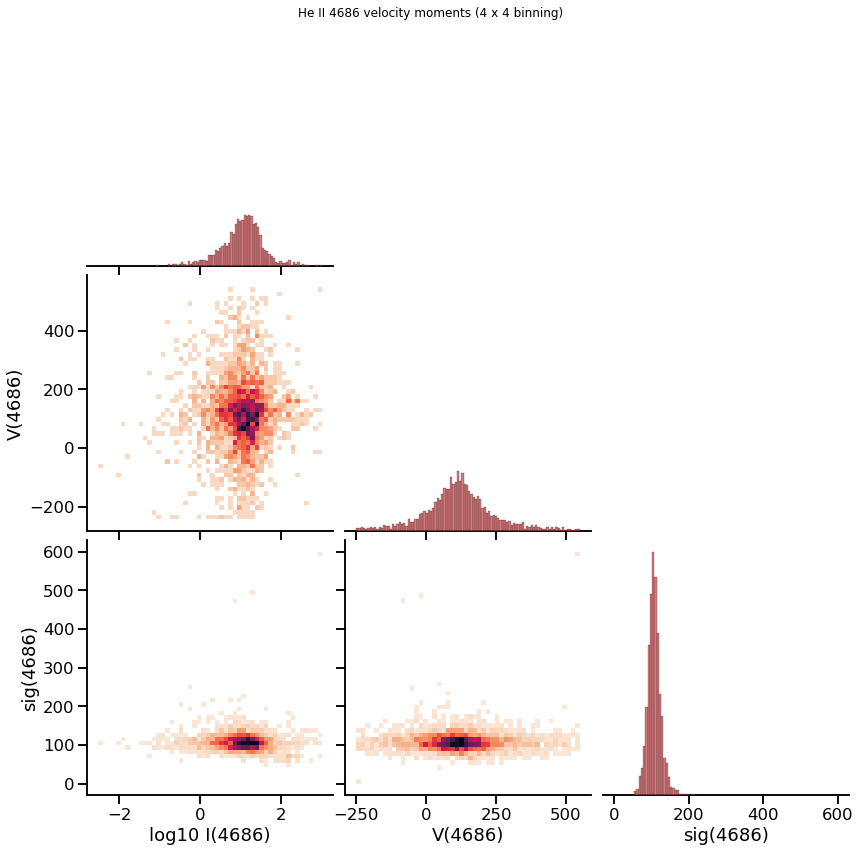

In [37]:
g = moments.moments_corner_plot(
    mom4686,
    rebin=4,
    **plot_pars_4686,
)

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/whispy/moments.py:127: RuntimeWarning: invalid value encountered in log10
  f"log10 I({label})": np.log10(irange),


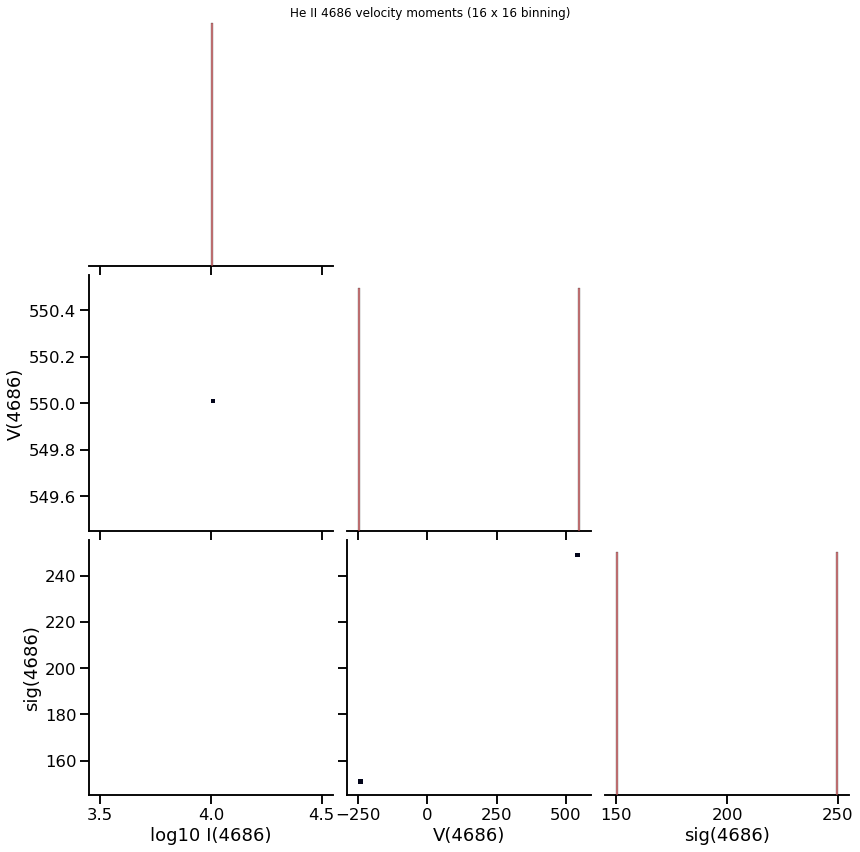

In [38]:
mom_pars_4686 = dict(
    restwav=4685.68,
    irange=[-1000, 1e4],
    vrange=[-250, 550],
    srange=[150, 250],
)
plot_pars_4686 = dict(
    ilabel="He II",
    label="4686",
    flabel="ngc346-heii",
    **mom_pars_4686,
)
g = moments.moments_corner_plot(
    mom4686,
    rebin=16,
    **plot_pars_4686,
)

Unfortunately, the velocity spread does not decrease with binning, although the sigma spread does.

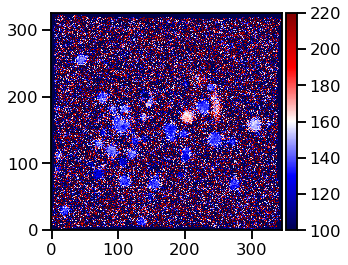

In [39]:
(3e5 * (mom4686[1] / 4685.68 - 1.0)).rebin(1).plot(
    vmin=100,
    vmax=220,
    cmap="seismic",
    colorbar="v",
)

In [40]:
map4686 = mom4686[0].copy()
map4686.mask = map4686.mask | (map4686.data < -100)

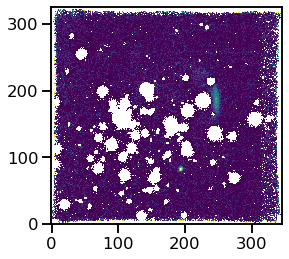

In [41]:
map4686.rebin(1).plot(
    vmin=0,
    vmax=500,
)

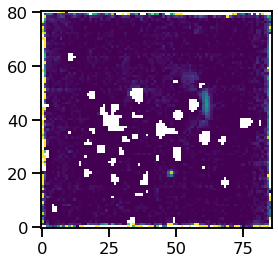

In [42]:
map4686.rebin(4).plot(
    vmin=0,
    vmax=500,
)

In [43]:
mom_pars_4686 = dict(
    restwav=4685.68,
    irange=None,
    vrange=None,
    srange=None,
)
moments.save_moments_to_fits(
    mom4686,
    label="4686",
    flabel="ngc346-heii",
    **mom_pars_4686,
)

In [44]:
# ## Extract [Ar IV] line
mom4740 = moments.find_moments(mcsubcube.select_lambda(4740, 4746))

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/whispy/moments.py:43: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)


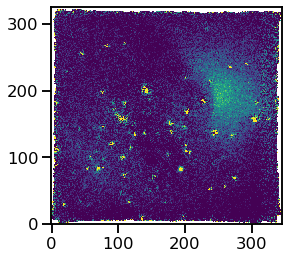

In [45]:
mom4740[0].plot(vmin=0.0, vmax=300.0)

In [46]:
mom_pars_4740 = dict(
    restwav=4740.17,
    irange=[-10, 1000],
    vrange=[-250, 550],
    srange=[0, 600],
)

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/whispy/moments.py:119: RuntimeWarning: invalid value encountered in log10
  f"log10 I({label})": np.log10(mom0.data[~m]),
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/whispy/moments.py:127: RuntimeWarning: invalid value encountered in log10
  f"log10 I({label})": np.log10(irange),


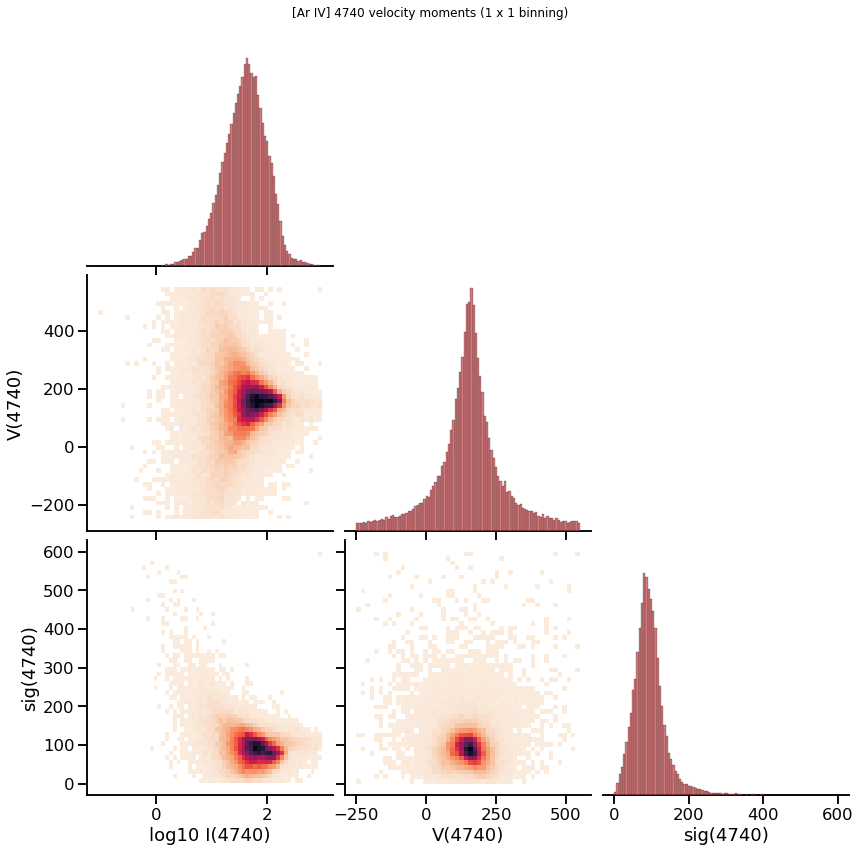

In [47]:
plot_pars_4740 = dict(
    ilabel="[Ar IV]",
    label="4740",
    flabel="ngc346-ariv",
    **mom_pars_4740,
)
g = moments.moments_corner_plot(
    mom4740,
    rebin=1,
    **plot_pars_4740,
)

In [48]:
moments.save_moments_to_fits(
    mom4740,
    label="4740",
    flabel="ngc346-ariv",
    restwav=4740.17,
)

And the other [Ar IV] line.  This is contaminated by He I, which we will have to sort out at some point.

In [49]:
mom4711 = moments.find_moments(mcsubcube.select_lambda(4711, 4717))

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/whispy/moments.py:43: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)


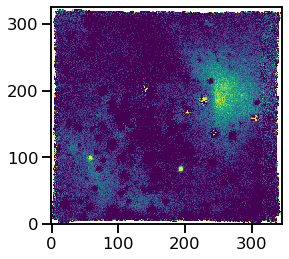

In [50]:
mom4711[0].plot(vmin=0.0, vmax=400.0)

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)


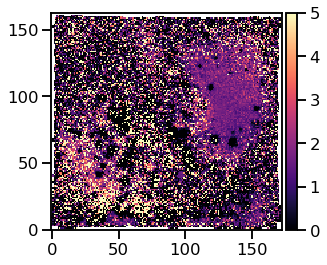

In [51]:
(mom4711[0].rebin(2) / mom4740[0].rebin(2)).plot(
    vmin=0.0,
    vmax=5,
    colorbar="v",
    cmap="magma",
)

So depite the contamination, the ratio is roughly constant at around 1.5 in the bright parts.

In [52]:
moments.save_moments_to_fits(
    mom4711,
    label="4711",
    flabel="ngc346-ariv",
    restwav=4711.37,
)

### Extract super-weak [Ar III] line

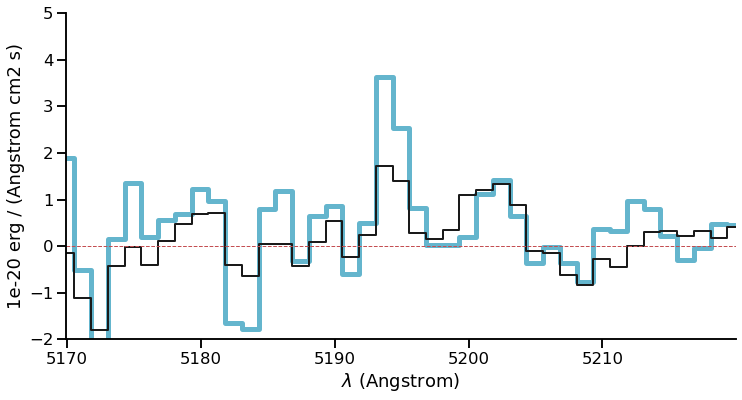

In [53]:
fig, ax = plt.subplots(figsize=(12, 6))
wav1, wav2 = 5170, 5220
(bowspec_sub).subspec(wav1, wav2).plot(linewidth=5, alpha=1.0, color="c")
(medspec_sub).subspec(wav1, wav2).plot(color="k", linewidth=2)
# for wav in ariv_lines:
#    ax.axvline(wav*(1.0 + 160.0/3e5), ymin=0.3, ymax=0.4, color="k", linewidth=3, alpha=0.5)
ax.axhline(0.0, linestyle="dashed", color="r", linewidth=1)
ax.set(
    ylim=[-2, 5],
)
sns.despine()

In [54]:
mom5192 = moments.find_moments(mcsubcube.select_lambda(5191, 5198))

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/whispy/moments.py:43: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)


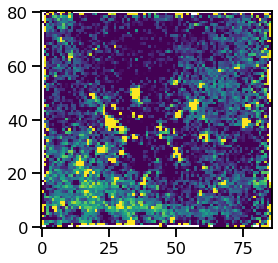

In [55]:
mom5192[0].rebin(4).plot(vmin=-3.0, vmax=40.0)

In [56]:
moments.save_moments_to_fits(
    mom5192,
    label="5192",
    flabel="ngc346-ariii",
    restwav=5191.82,
)

### Extract He I 4922

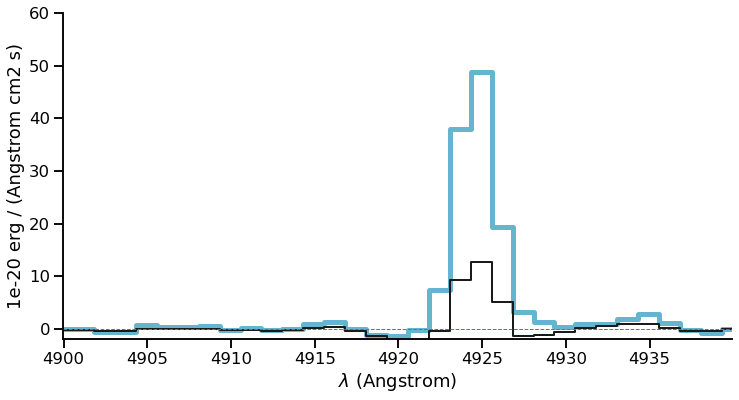

In [57]:
fig, ax = plt.subplots(figsize=(12, 6))
wav1, wav2 = 4900, 4940
(bowspec_sub).subspec(wav1, wav2).plot(linewidth=5, alpha=1.0, color="c")
(medspec_sub).subspec(wav1, wav2).plot(color="k", linewidth=2)
# for wav in ariv_lines:
#    ax.axvline(wav*(1.0 + 160.0/3e5), ymin=0.3, ymax=0.4, color="k", linewidth=3, alpha=0.5)
ax.axhline(0.0, linestyle="dashed", color="r", linewidth=1)
ax.set(
    ylim=[-2, 60],
)
sns.despine()

In [58]:
mom4922 = moments.find_moments(mcsubcube.select_lambda(4921, 4929))

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/whispy/moments.py:43: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)


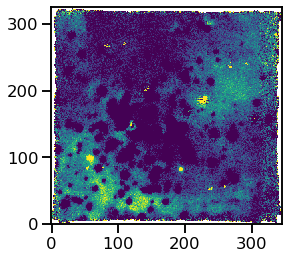

In [59]:
mom4922[0].rebin(1).plot(vmin=-30.0, vmax=300.0)

This one is good enough signal to see the increase in brightness at the bow shock.

In [60]:
moments.save_moments_to_fits(
    mom4922,
    label="4922",
    flabel="ngc346-hei",
    restwav=4921.93,
)

### Extract He I 5048 line

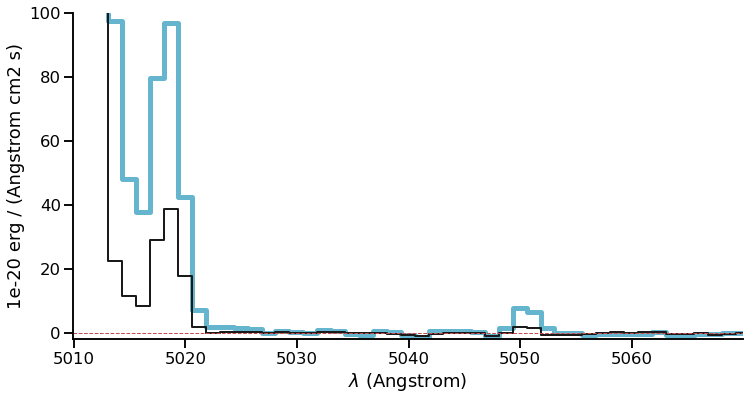

In [61]:
fig, ax = plt.subplots(figsize=(12, 6))
wav1, wav2 = 5010, 5070
(bowspec_sub).subspec(wav1, wav2).plot(linewidth=5, alpha=1.0, color="c")
(medspec_sub).subspec(wav1, wav2).plot(color="k", linewidth=2)
# for wav in ariv_lines:
#    ax.axvline(wav*(1.0 + 160.0/3e5), ymin=0.3, ymax=0.4, color="k", linewidth=3, alpha=0.5)
ax.axhline(0.0, linestyle="dashed", color="r", linewidth=1)
ax.set(
    ylim=[-2, 100],
)
sns.despine()

In [62]:
mom5048 = moments.find_moments(mcsubcube.select_lambda(5047, 5055))

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/whispy/moments.py:43: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)


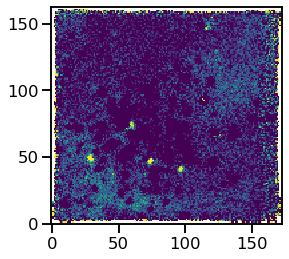

In [63]:
mom5048[0].rebin(2).plot(vmin=-3.0, vmax=100.0)

In [64]:
moments.save_moments_to_fits(
    mom5048,
    label="5048",
    flabel="ngc346-hei",
    restwav=5047.74,
)

## Extract Hβ line

In [65]:
mom4861 = moments.find_moments(mcsubcube.select_lambda(4859, 4869))

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/whispy/moments.py:43: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)


Overview before correcting the sky:

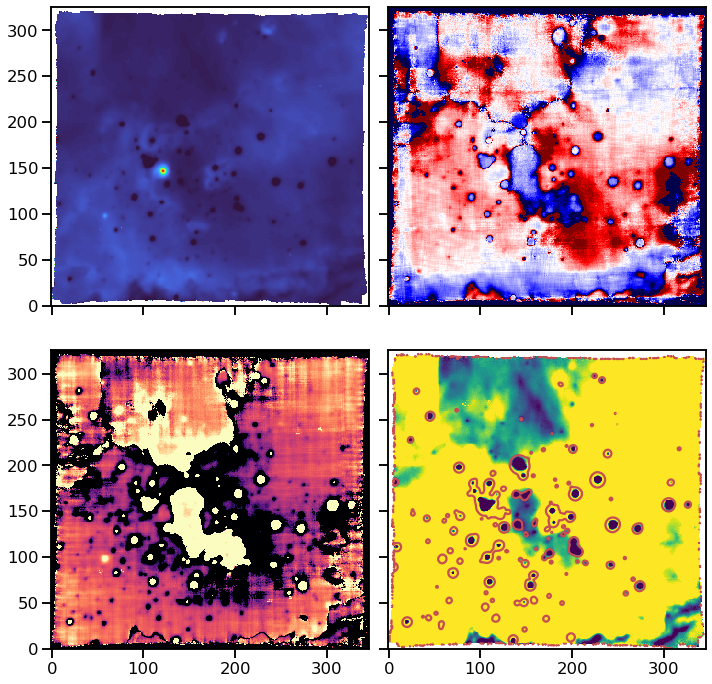

In [66]:
fig, axes = plt.subplots(
    2,
    2,
    figsize=(10, 10),
    sharex=True,
    sharey=True,
)

imap = mom4861[0].copy()
vmap = 3e5 * (mom4861[1] / 4861.32 - 1.0)
smap = 3e5 * (mom4861[2] / 4861.32)

# m = imap.data > 10.

# vmap.mask = vmap.mask | (~m)
# smap.mask = smap.mask | (~m)

imap.rebin(1).plot(
    vmin=-1e4,
    vmax=3e5,
    cmap="turbo",
    ax=axes[0, 0],
)

vmap.rebin(1).plot(
    vmin=100,
    vmax=220,
    cmap="seismic",
    ax=axes[0, 1],
)

smap.rebin(1).plot(
    vmin=0,
    vmax=120,
    cmap="magma",
    ax=axes[1, 0],
)

imap.rebin(1).plot(
    vmin=-5000,
    vmax=0,
    cmap="viridis",
    ax=axes[1, 1],
)
bg_4861 = mcontcube.select_lambda(4859, 4869).mean(axis=0)
axes[1, 1].contour(
    bg_4861.data,
    levels=[1000],
    colors="r",
)

fig.tight_layout()

Make a 30 Å window:

In [67]:
core_4861 = mcsubcube.select_lambda(4849, 4879)

Look at some negative profiles.  These are the same pixels as used in the Hα case.  See 03-00-ha-moment-maps

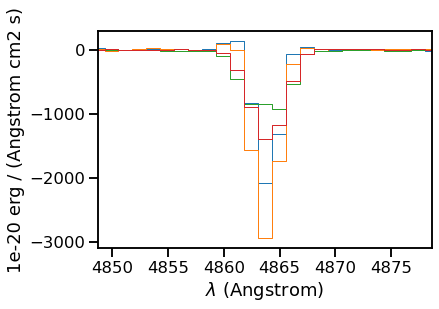

In [68]:
core_4861[:, 300, 60].plot()
core_4861[:, 10, 300].plot()
core_4861[:, 150, 150].plot()
core_4861[:, 260, 160].plot()
# I am following the same procedure as with the [O I] lines, but with criteria similar to H alpha.

In [69]:
msky = (imap.data < -4000) & (imap.data > -5000) & (bg_4861.data < 1000)
msky[310:, :] = False
msky[:, 320:] = False
msky[:10, :] = False
msky[:, :10] = False

In [70]:
msky.sum(), np.where(msky)

(1039,
 (array([ 10,  10,  10, ..., 309, 309, 309]),
  array([88, 97, 98, ..., 66, 85, 86])))

No, that is too many. We will try the same 3 pixels as we used for Hα

In [71]:
msky = imap.mask.copy()
msky[:, :] = False
msky[8, 103:106] = True
np.where(msky)

(array([8, 8, 8]), array([103, 104, 105]))

In [72]:
sky_4861 = core_4861.copy()
sky_4861.mask = sky_4861.mask | ~msky[None, ::]

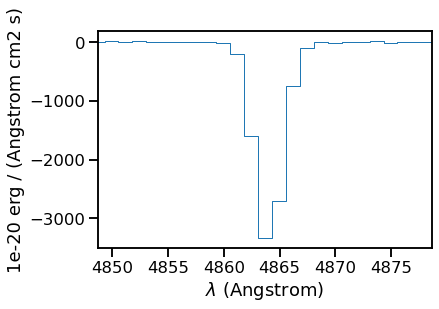

In [73]:
sky_4861.mean(axis=(1, 2)).plot()

In [74]:
corr_4861 = core_4861 - sky_4861.mean(axis=(1, 2))

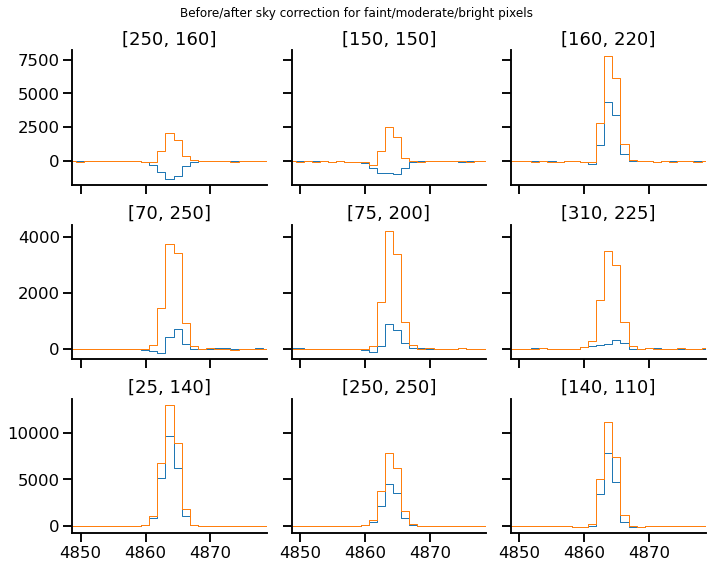

In [75]:
testpixels = [
    [250, 160],
    [150, 150],
    [160, 220],
    [70, 250],
    [75, 200],
    [310, 225],
    [25, 140],
    [250, 250],
    [140, 110],  # [180, 290],
]
fig, axes = plt.subplots(
    3,
    3,
    figsize=(10, 8),
    sharex=True,
    sharey="row",
)
for (j, i), ax in zip(testpixels, axes.flat):
    core_4861[:, j, i].plot(ax=ax)
    corr_4861[:, j, i].plot(ax=ax)
    ax.set(xlabel="", ylabel="")
    ax.set_title(f"[{j}, {i}]")
fig.suptitle("Before/after sky correction for faint/moderate/bright pixels")
sns.despine()
fig.tight_layout()

That looks OK

In [76]:
mom4861c = moments.find_moments(corr_4861.select_lambda(4859, 4869))

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/whispy/moments.py:43: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)


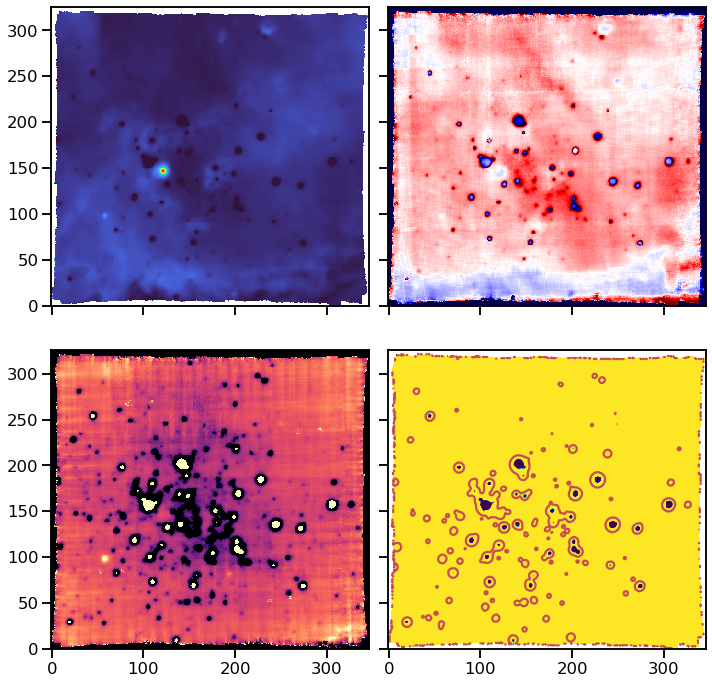

In [77]:
fig, axes = plt.subplots(
    2,
    2,
    figsize=(10, 10),
    sharex=True,
    sharey=True,
)

imap = mom4861c[0].copy()
vmap = 3e5 * (mom4861c[1] / 4861.32 - 1.0)
smap = 3e5 * (mom4861c[2] / 4861.32)

# m = imap.data > 10.

# vmap.mask = vmap.mask | (~m)
# smap.mask = smap.mask | (~m)

imap.rebin(1).plot(
    vmin=0,
    vmax=3e5,
    cmap="turbo",
    ax=axes[0, 0],
)

vmap.rebin(1).plot(
    vmin=100,
    vmax=220,
    cmap="seismic",
    ax=axes[0, 1],
)

smap.rebin(1).plot(
    vmin=0,
    vmax=120,
    cmap="magma",
    ax=axes[1, 0],
)

imap.rebin(1).plot(
    vmin=-5000,
    vmax=0,
    cmap="viridis",
    ax=axes[1, 1],
)
bg_4861 = mcontcube.select_lambda(4859, 4869).mean(axis=0)
axes[1, 1].contour(
    bg_4861.data,
    levels=[1000],
    colors="r",
)

fig.tight_layout()

That is looking great now.  The first moment is very similat to Hα, which is encouraging.

In [78]:
mom_pars = dict(
    restwav=4861.32,
    irange=[1.0e3, 3.5e5],
    vrange=[135, 195],
    srange=[30, 150],
)

In [79]:
moments.save_moments_to_fits(
    mom4861c,
    label="4861",
    flabel="ngc346-hi",
    **mom_pars,
)

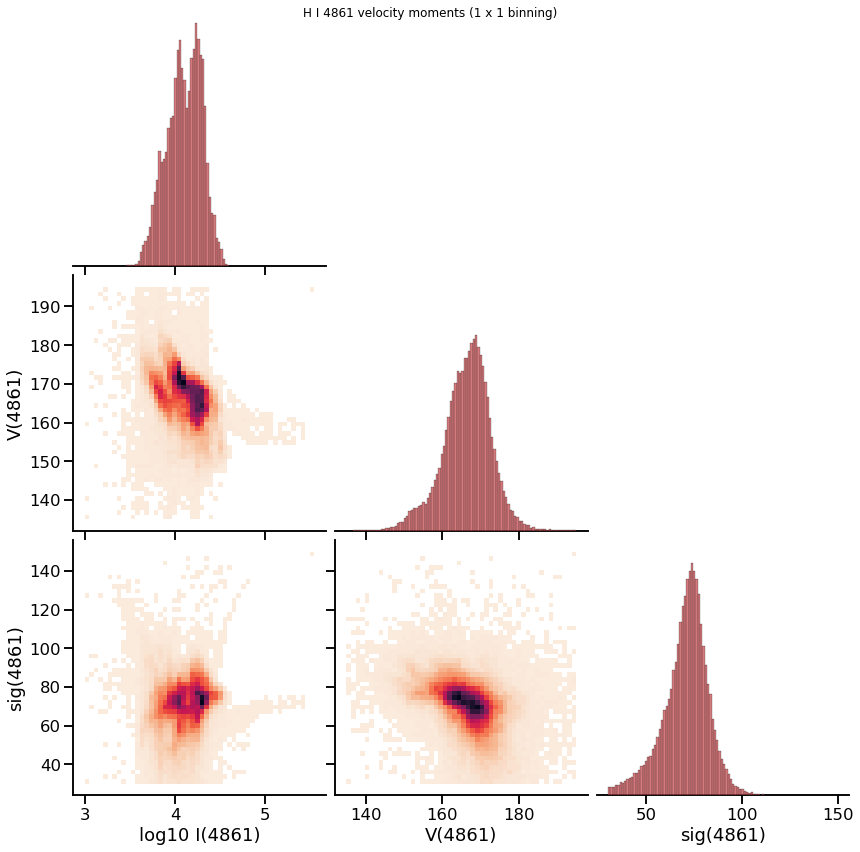

In [80]:
plot_pars = dict(
    ilabel="H I",
    label="4861",
    flabel="ngc346-hi",
    **mom_pars,
)
g = moments.moments_corner_plot(
    mom4861c,
    rebin=1,
    **plot_pars,
)